In [301]:
import os
import math
import gzip
import pickle
import random

from glob import glob
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

import spacy

from collections import defaultdict

#nlp = spacy.load('pt', disable=['parser', 'tagger', 'ner'])
nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])
#tokenizar = spacy.tokenizer.Tokenizer(nlp.vocab)

In [656]:
project_repos = {'mesos': 'apache', 'usergrid': 'apache', 'appceleratorstudio': 'appcelerator', 
    'aptanastudio': 'appcelerator', 'titanium': 'appcelerator', 'duracloud': 'duraspace', 'bamboo': 'jira',
    'clover': 'jira', 'jirasoftware': 'jira', 'moodle': 'moodle', 'datamanagement': 'lsstcorp', 'mule': 'mulesoft',
    'mulestudio': 'mulesoft', 'springxd': 'spring', 'talenddataquality': 'talendforge', 'talendesb': 'talendforge'
}
story_points_clip = {'mesos': 5.0, 'usergrid': 5.0, 'appceleratorstudio': 8.0, 
    'aptanastudio': 13.0, 'titanium': 13.0, 'duracloud': 4.0, 'bamboo': 5.0, 
    'clover': 13.0, 'jirasoftware': 8.0, 'moodle': 40.0, 'datamanagement': 21.0, 'mule': 8.0,
    'mulestudio': 13.0, 'springxd': 8.0, 'talenddataquality': 13.0, 'talendesb': 3.0
}
deepse_baseline = {'mesos': 1.02, 'usergrid': 1.03, 'appceleratorstudio': 1.36,
    'aptanastudio': 2.71, 'titanium': 1.97, 'duracloud': 0.68, 'bamboo': 0.74,
    'clover': 2.11, 'jirasoftware': 1.38, 'moodle': 5.97, 'datamanagement': 3.77, 'mule': 2.18,
    'mulestudio': 3.23, 'springxd': 1.63, 'talenddataquality': 2.97, 'talendesb': 0.64
}
project_name = {'mesos': 'Mesos', 'usergrid': 'Usergrid', 'appceleratorstudio': 'Appcelerator Studio',
    'aptanastudio': 'Aptana Studio', 'titanium': 'Titanium SDK/CLI', 'duracloud': 'DuraCloud', 'bamboo': 'Bamboo',
    'clover': 'Clover', 'jirasoftware': 'Jira Software', 'moodle': 'Moodle', 'datamanagement': 'Data Management', 'mule': 'Mule',
    'mulestudio': 'Mule Studio', 'springxd': 'Spring XD', 'talenddataquality': 'Talend Data Quality', 'talendesb': 'Talend ESB'
}
repo_name = {'apache': 'Apache', 'appcelerator': 'Appcelerator', 'duraspace': 'DuraSpace', 'jira': 'Atlassian',
    'moodle': 'Moodle', 'lsstcorp': 'LSST Corporation', 'mulesoft': 'MuleSoft', 'spring': 'Spring', 'talendforge': 'TalendForge'
}
save_paths = {'pretrain_data': 'data/pretrain/%s_pretrain.csv', 'train_data': 'data/train/%s.csv',
    'dic': 'models/en/dic/%s.dic.pkl', 'log_pre': 'logs/en/pretrain/%s.csv', 'hist_pre': 'logs/en/pretrain/%s.pkl',
    'model_pre': 'models/en/pretrain/%s.h5', 'log': 'logs/en/train/%s.csv', 'hist': 'logs/en/train/%s.pkl',
    'model': 'models/en/train/%s.h5', 'prediction_errors': 'logs/en/test/%s.csv'
}

ccasj_repos = {'ccasj': 'ccasj'}
ccasj_clip = {'ccasj': 12.5}
ccasj_baseline = {'ccasj': 3.1}
ccasj_project_name = {'ccasj': 'CCA-SJ Projects'}
ccasj_repo_name = {'ccasj': 'CCA-SJ'}
ccasj_save = {k:v.replace('/en/', '/pt_BR/') for k, v in save_paths.items()}

tex_output = 'reports/tables/%s.tex'

In [724]:
[print(v, end=', ') for v in sorted(list(project_name.values()))]

Appcelerator Studio, Aptana Studio, Bamboo, Clover, Data Management, DuraCloud, Jira Software, Mesos, Moodle, Mule, Mule Studio, Spring XD, Talend Data Quality, Talend ESB, Titanium SDK/CLI, Usergrid, 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [707]:
data = {k: pd.read_csv(save_paths['train_data'] % k)['storypoint'] for k in project_repos.keys()}
data_table = pd.DataFrame.from_dict({k: 
    [project_name[k], repo_name[project_repos[k]], v.mean(), v.median(), v.autocorr(), v.count(), v.std(), v.min(), v.max()] #, v.kurtosis(), v.mad(), v.mode()[0], v.skew()]
    for k, v in data.items()}, orient='index',
    columns=['Project', 'Repository', 'Mean', 'Median', 'Autocorr.', 'Count', 'Std.', 'Min.', 'Max.'])#, 'Kurtosis', 'MAD', 'Mode', 'Skew'])
with open('reports/tables/data.tex', 'w') as file:
    data_table.to_latex(index=False, buf=file)
data_table

,Project,Repository,Mean,Median,Autocorr.,Count,Std.,Min.,Max.
mesos,Mesos,Apache,3.09,3.00,0.18,1680,2.42,1,40
usergrid,Usergrid,Apache,2.85,3.00,0.12,482,1.40,1,8
appceleratorstudio,Appcelerator Studio,Appcelerator,5.64,5.00,0.26,2919,3.33,1,40
aptanastudio,Aptana Studio,Appcelerator,8.02,8.00,0.23,829,5.95,1,40
titanium,Titanium SDK/CLI,Appcelerator,6.32,5.00,0.21,2251,5.10,1,34
duracloud,DuraCloud,DuraSpace,2.13,1.00,0.24,666,2.03,1,16
bamboo,Bamboo,Atlassian,2.42,2.00,0.15,521,2.14,1,20
clover,Clover,Atlassian,4.59,2.00,0.39,384,6.55,1,40
jirasoftware,Jira Software,Atlassian,4.43,3.00,0.35,352,3.51,1,20
moodle,Moodle,Moodle,15.54,8.00,0.16,1166,21.65,1,100


In [720]:
clip_table = pd.DataFrame.from_dict({k: (project_name[k], v, (data[k]>v).sum(), data[k].clip(0,v).mean(), data[k].clip(0,v).std()) for k, v in story_points_clip.items()}, orient='index', columns=['Project', 'Maximum Cliped Story point', 'Count Cliped', 'Mean', 'Std.'])
with open('reports/tables/data-clip.tex', 'w') as file:
    clip_table.to_latex(index=False, buf=file)

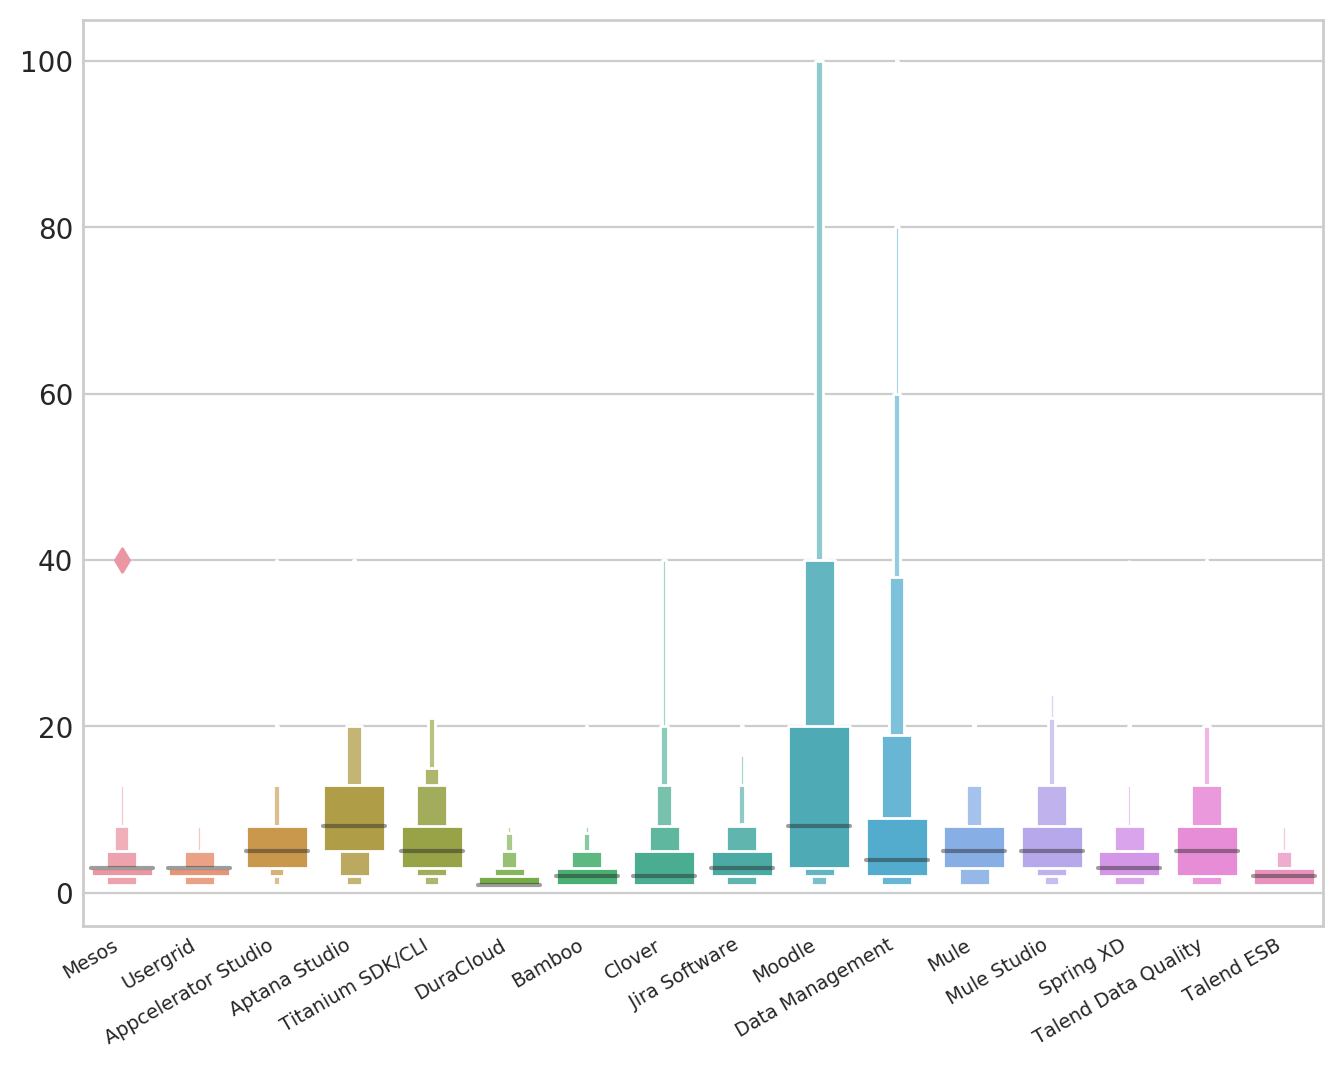

In [706]:
figura = plt.figure(figsize=(8, 6), dpi=200)
#plt.yscale('log')
sns.boxenplot(data = list(data.values()))
plt.xticks(list(range(len(data))), [project_name[k] for k in data.keys()], rotation=30, horizontalalignment='right', fontsize='x-small')
plt.show()
figura.savefig("reports/figures/data-boxplot.pdf", bbox_inches='tight')

In [692]:
plt.xticks?

In [ ]:
with gzip.open('/home/gmelo/python-virtual-environments/datasets/storypoint/IEEE TSE2018/Deep-SE/data/ccasj.pkl.gz', 'rb') as f:
    c = pickle.load(f, encoding='latin1')
c[8].max()

In [568]:
def baseline_zero(data_file_path, max_value=999999, test_fraction = 0.2):
    story_points = pd.read_csv(data_file_path)['storypoint'].values.clip(0, max_value).astype('int32')
    num_test = int(round(len(story_points) * test_fraction))
    count_train = np.bincount(story_points[:-num_test], minlength=story_points.max())
    count_train = count_train/np.sum(count_train)
    count_test = np.bincount(story_points[-num_test:], minlength=story_points.max())
    count_test = count_test/np.sum(count_test)
    count = np.dot(count_train.reshape((-1,1)), count_test.reshape((1, -1)))
    random_mae = 0
    for i in range(1, count.shape[0]):
        random_mae += i * (count.trace(i) + count.trace(-i))
    median_mae = np.mean(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_mdae = np.median(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_sa = (1 - median_mae/random_mae) * 100
    mean_mae = np.mean(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_mdae = np.median(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_sa = (1 - mean_mae/random_mae) * 100
    return [mean_mae, mean_mdae, mean_sa, median_mae, median_mdae, median_sa]

def baseline_zero2(data_file_path, max_value=999999, test_fraction = 0.2):
    story_points = pd.read_csv(data_file_path)['storypoint'].values.clip(0, max_value).astype('int32')
    num_test = int(round(len(story_points) * test_fraction))
    num_train = len(story_points) - num_test
    random_mae = np.mean([np.mean(np.abs(story_points[np.random.randint(0, num_train, num_test)] - story_points[-num_test:])) for i in range(100)])
    median_mae = np.mean(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_mdae = np.median(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_sa = (1 - median_mae/random_mae) * 100
    mean_mae = np.mean(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_mdae = np.median(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_sa = (1 - mean_mae/random_mae) * 100
    return [mean_mae, mean_mdae, mean_sa, median_mae, median_mdae, median_sa]

In [578]:
metrics = {}
for project in project_repos.keys():
    metrics[project] = [project_name[project]] + baseline_zero(save_paths['train_data'] % project, story_points_clip[project])
metrics['ccasj'] = [ccasj_project_name['ccasj']] + baseline_zero2(ccasj_save['train_data'] % 'ccasj', max_value=ccasj_clip['ccasj'])
table = pd.DataFrame.from_dict(metrics, orient='index', columns=['Project', 'Mean MAE', 'Mean MdAE', 'Mean SA', 'Median MAE', 'Median MdAE', 'Median SA']).drop('ccasj')
table

,Project,Mean MAE,Mean MdAE,Mean SA,Median MAE,Median MdAE,Median SA
mesos,Mesos,1.11,0.78,27.78,1.12,1.00,27.61
usergrid,Usergrid,1.09,0.76,19.48,1.03,1.00,23.88
appceleratorstudio,Appcelerator Studio,1.43,0.28,37.14,1.28,0.00,43.98
aptanastudio,Aptana Studio,3.01,2.45,30.80,3.08,3.00,29.13
titanium,Titanium SDK/CLI,2.46,2.03,32.25,1.95,2.00,46.24
duracloud,DuraCloud,0.72,0.87,29.65,0.74,1.00,27.72
bamboo,Bamboo,0.93,1.00,25.90,0.76,1.00,39.44
clover,Clover,2.80,2.93,21.27,2.31,1.00,35.02
jirasoftware,Jira Software,1.67,1.13,31.43,1.36,1.00,44.29
moodle,Moodle,10.32,11.14,14.84,6.46,5.00,46.71


In [ ]:
with open(tex_output % 'deep-se-mean-reproduction', 'w') as file:
    table.to_latex(index=False, columns=['Project', 'Mean MAE', 'Mean MdAE', 'Mean SA'], buf=file)
with open(tex_output % 'deep-se-median-reproduction', 'w') as file:
    table.to_latex(index=False, columns=['Project', 'Median MAE', 'Median MdAE', 'Median SA'], buf=file)

In [581]:
repro_ae_melhor = {}
for path in glob('/home/gmelo/python-virtual-environments/datasets/storypoint/IEEE TSE2018/Deep-SE/classification/log/*.txt'):
    project = path.split('/')[-1]
    dim = project.split('_')[3].split('dim')[-1]
    project = project.split('_')[0]
    with open(path) as file:
        a = file.read()
    linha_melhor = int(a[-20:].split('epoch')[-1].strip())
    v_mae = a.split('\n')[linha_melhor+1].split('\t')[4]
    t_mae = a.split('\n')[linha_melhor+1].split('\t')[9]
    if not repro_ae_melhor.get(project) or v_mae < repro_ae_melhor[project][0]:
        repro_ae_melhor[project] = (v_mae, dim, t_mae)
repro_ae = {'mean': {}, 'median': {}, 'sa': {}, 'raw': {}}
for path in glob('/home/gmelo/python-virtual-environments/datasets/storypoint/IEEE TSE2018/Deep-SE/classification/log/ar/raw_*.txt'):
    project = path.split('/')[-1]
    dim = project.split('_')[4].split('dim')[-1]
    project = project.split('_')[1]
    aes = np.loadtxt(path)
    repro_ae['raw'][project+'_'+dim] = aes
    repro_ae['mean'][project+'_'+dim] = np.mean(np.abs(aes))
    repro_ae['median'][project+'_'+dim] = np.median(np.abs(aes))
    repro_ae['sa'][project+'_'+dim] = 100 - ((100 - metrics[project][3]) / metrics[project][1] * np.mean(np.abs(aes)))
repro = {}
for project in list(project_repos.keys()):
    dim = repro_ae_melhor[project][1]
    repro[project] = (project_name[project], repro_ae['mean'][project+'_'+dim], repro_ae['median'][project+'_'+dim], repro_ae['sa'][project+'_'+dim])
tab_repro = pd.DataFrame.from_dict(repro, orient='index', columns=['Project', 'Mean Average Error', 'Median Average Error', 'Gain over Random'])
with open('reports/tables/deep-se-reproduction.tex', 'w') as file:
    tab_repro.to_latex(index=False, buf=file)

novo modelo

In [540]:
repro_ae = {'mean': {}, 'median': {}, 'sa': {}, 'raw': {}}
for path in glob('logs/en/test/*.csv'):
    project = path.split('/')[-1].split('.')[0]
    if project == 'ccasj':
        continue
    aes = np.loadtxt(path)
    repro_ae['raw'][project] = aes
    repro_ae['mean'][project] = np.mean(np.abs(aes))
    repro_ae['median'][project] = np.median(np.abs(aes))
    repro_ae['sa'][project] = 100 - ((100 - metrics[project][3]) / metrics[project][1] * np.mean(np.abs(aes)))
repro = {}
for project in project_repos.keys():
    repro[project] = (project_name[project], repro_ae['mean'][project], repro_ae['median'][project], repro_ae['sa'][project])
tab_repro = pd.DataFrame.from_dict(repro, orient='index', columns=['Project', 'Mean Average Error', 'Median Average Error', 'Gain over Random'])
with open('reports/tables/results-datasets.tex', 'w') as file:
    tab_repro.to_latex(index=False, buf=file)

CCA

In [725]:
project = 'ccasj'
story_points = pd.read_csv(ccasj_save['train_data'] % 'ccasj')['storypoint'].values.clip(0, ccasj_clip['ccasj']).astype('int32')
num_test = int(round(len(story_points) * test_fraction))
num_train = len(story_points) - num_test
random_mae = np.mean([np.mean(np.abs(story_points[np.random.randint(0, num_train, num_test)] - story_points[-num_test:])) for i in range(100)])
random_mdae = np.mean(np.abs(story_points[np.random.randint(0, num_train, num_test)] - story_points[-num_test:]))
dim_ccasj_melhor = repro_ae_melhor[project][1]
ccasj_melhor = (repro_ae['mean'][project+'_'+dim], repro_ae['median'][project+'_'+dim], repro_ae['sa'][project+'_'+dim])
ccasj_resultados = np.loadtxt(ccasj_save['prediction_errors'] % project)
ccasj_table = {'Random': (random_mae, random_mdae, 0), 'Mean': metrics[project][1:4], 'Median': metrics[project][4:], 'Deep-SE':ccasj_melhor, 
               'Proposed': (np.mean(ccasj_resultados),np.median(ccasj_resultados),100- 100.0*np.mean(ccasj_resultados)/random_mae)}
ccasj_table = {k: [k] + list(v) for k,v in ccasj_table.items()}
ccasj_table = pd.DataFrame.from_dict(ccasj_table, orient='index', columns=['Method', 'Mean Average Error', 'Median Average Error', 'Gain over Random'])
with open('reports/tables/results-ccasj.tex', 'w') as file:
    ccasj_table.to_latex(index=False, buf=file)

In [589]:
metrics[project][4:]

[3.5984126984126985, 2.0, 17.995131073949068]

In [502]:
test_fraction = 0.2
val_fraction = 0.2

def ler_csv_texto_tokenizado(caminho_arquivo, tokenizador):
    tabela_dados = pd.read_csv(caminho_arquivo)
    titulos = tabela_dados.values[:, 1].astype('str')
    separadores = np.full(len(titulos), '. ')
    descricao = tabela_dados.values[:, 2].astype('str')
    valores = tabela_dados.values[:, 3].astype('float32')
    juntos = [a + b + c for a, b, c in zip(titulos, separadores, descricao)]
    tokenizados = [[w.text.strip().lower() for w in tokenizador(frase) if not w.text.isspace()] for frase in juntos]
    return tokenizados, valores

def gerar_dicionario(lista_tokens, vocabulario_maximo=2000):
    contagem = defaultdict(int)
    for tokens in lista_tokens:
        for token in tokens:
            contagem[token] += 1
    ordenadas = sorted(contagem.items(), key=lambda x: x[1], reverse=True)
    IDs = {'EOF_VALUE': 0, 'UNK_VALUE': 1}
    for i in range(min(vocabulario_maximo, len(ordenadas))): # EOF = 0, ID_desconhecido = 1
        IDs[ordenadas[i][0]] = i + 2
    return IDs

def converte_tokens_pretreino(lista_tokens, dic):
    dados = [np.array([(dic.get(tk) or 1) for tk in tks], dtype=np.int16) for tks in lista_tokens]
    return dados

def converte_tokens_treino(lista_tokens, dic, fracao_valida = 0.2, fracao_teste = 0.2, tamanho_frase=256):
    dados = np.zeros((len(lista_tokens), tamanho_frase), dtype='int16')
    for i, tks in enumerate(lista_tokens):
        compri = min(tamanho_frase, len(tks))
        dados[i, :compri] = [(dic.get(tks[i]) or 1) for i in range(compri)]
    quant_valida = int(fracao_valida * len(lista_tokens))
    quant_teste = int(fracao_teste * len(lista_tokens))
    return dados[:-quant_valida-quant_teste], dados[-quant_valida-quant_teste:-quant_teste], dados[-quant_teste:]

In [ ]:
unlabelled_words, _ = ler_csv_texto_tokenizado('data/pretrain/moodle_pretrain.csv', nlp.tokenizer)
story_words, story_points = ler_csv_texto_tokenizado('data/train/moodle.csv', nlp.tokenizer)
dic = gerar_dicionario(unlabelled_words + story_words)

#treino, validacao = converte_tokens_pretreino(a, dic)
pretrain_tokens = converte_tokens_pretreino(unlabelled_words + story_words, dic)
print('Vocabulario: ', len(dic), '\nTreino: ', len(pretrain_tokens))#, '\n Validação: ', len(validacao))

In [ ]:
num_test = int(round(len(story_words) * test_fraction))
num_val = int(round(len(story_words) * val_fraction))
num_train = len(story_words) - num_test - num_val

In [ ]:
story_words, story_points = ler_csv_texto_tokenizado('data/train/moodle.csv', nlp.tokenizer)

In [352]:
np.mean(np.abs(np.median(story_points.clip(1, 40)[:800])- story_points.clip(1,40)[:800]))

9.3

In [347]:
len(story_points)

1166

(array([599., 184.,   0.,  68.,   0.,  14.,   0.,   1.,   0.,   2.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <a list of 10 Patch objects>)

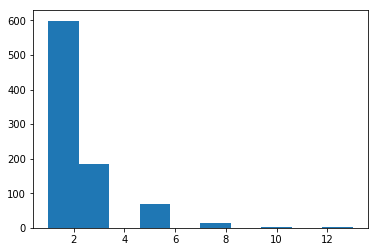

In [232]:
plt.hist(story_points)

In [ ]:
p = converte_tokens_pretreino(story_words, dic)

In [ ]:
sum(np.sum(i==1) for i in p)/sum(np.sum(i>0) for i in p)

In [ ]:
len(story_points)

In [ ]:
np.sum(story_points==1)/len(story_points)

In [ ]:
np.median(np.clip(story_points[:num_train], 1, 40))

In [ ]:
np.mean(np.abs(np.median(story_points[:num_train]) - story_points[num_train:num_train+num_val]))

In [ ]:
np.mean(np.abs(np.median(np.clip(story_points[:num_train], 1, 40))-np.clip(story_points[-num_test-num_val:-num_test], 1, 40)))

In [ ]:
np.mean(np.abs(np.median(np.clip(story_points[:num_train], 1, 40))-np.clip(story_points[-num_test-num_val:-num_test], 1, 40)))

In [ ]:
np.mean(np.abs(np.median(np.clip(story_points[:-num_test], 1, 40))-np.clip(story_points[-num_test:], 1, 40)))

In [ ]:
story_points[num_train-4+num_val:-num_test]

In [ ]:
story_points[:num_train].reshape((-1,1))

In [ ]:
np.sum(story_points[:num_train])

In [ ]:
np.mean(np.abs(np.median(np.clip(story_points[num_train:],1,40))-np.clip(story_points[-num_test:],1,40)))

In [7]:
metrics = pd.DataFrame(columns=['Project', 'Median MAE', 'Median MdAE', 'Median SA', 'Mean MAE', 'Mean MdAE', 'Mean SA'])

In [47]:
table

,Median MAE,Median MdAE,Median SA,Mean MAE,Mean MdAE,Mean SA
mesos,1.220238,1,44.637630,1.325255,1.169643,39.872994
usergrid,1.156250,1,16.827786,1.200291,0.823834,13.659765
appceleratorstudio,1.303082,0,58.958998,1.736270,0.776017,45.315611
aptanastudio,3.614458,3,38.242540,3.749587,3.215686,35.933699
titanium,2.040000,2,58.096886,2.869327,1.581344,41.061895
duracloud,0.796992,1,50.824920,0.908731,1.210131,43.930591
bamboo,0.759615,1,55.993298,1.068553,1.000000,38.095664
clover,3.636364,1,27.792191,4.383857,3.498371,12.949101
jirasoftware,1.571429,1,53.752355,2.093009,1.617021,38.402073
moodle,6.459227,5,64.331715,12.895712,14.647374,28.789017


In [342]:
ccasj = pd.read_csv('dados/treino/ccasj.csv')

In [484]:
v = ccasj.storypoint.values
t = int(len(v)*0.2)
np.mean(np.abs(np.median(v[:-2*t])-v[-t:].clip(1,21)))

4.496104928228075

In [483]:
np.median(v[:-2*t].clip(1,21))

1.5

In [482]:
np.mean(v[-t:])

8.198585055194002

In [343]:
ccasj.storypoint.max()

316.0

In [159]:
ccasjp = pd.read_csv('dados/pretreino/ccasj.csv')

In [165]:
xp = ccasjp.estimated_hours.values
n = int(len(xp)*0.2)
np.sum(xp)

17304.877003407106

In [166]:
np.mean(np.abs(np.median(xp[:-n])-xp[-n:]))

0.36788392565928263

In [90]:
ccasj.estimated_hours.max()

316.0

In [103]:
ccasj.estimated_hours.hist?

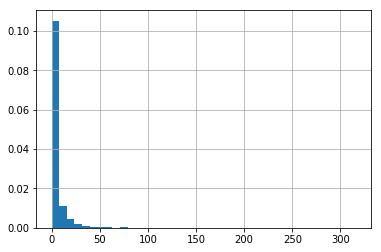

In [111]:
ccasj.estimated_hours.hist(bins=40, normed=True)

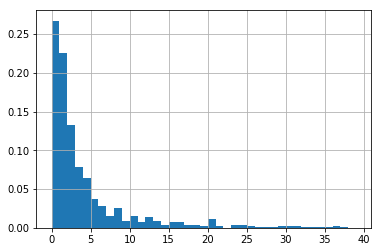

In [110]:
ccasj.estimated_hours.hist(bins=range(40), normed=True)

In [127]:
np.sum(ccasj.estimated_hours.values>50)

41

In [131]:
ccasj.estimated_hours.min()

0.009999999776482582

In [134]:
np.logspace(np.log10(ccasj.estimated_hours.min()), np.log10(40), 100)

array([9.99999978e-03, 1.08738775e-02, 1.18241214e-02, 1.28574050e-02,
       1.39809849e-02, 1.52027521e-02, 1.65312867e-02, 1.79759190e-02,
       1.95467944e-02, 2.12549452e-02, 2.31123675e-02, 2.51321058e-02,
       2.73283445e-02, 2.97165076e-02, 3.23133670e-02, 3.51371601e-02,
       3.82077182e-02, 4.15466055e-02, 4.51772707e-02, 4.91252117e-02,
       5.34181544e-02, 5.80862479e-02, 6.31622756e-02, 6.86818861e-02,
       7.46838430e-02, 8.12102975e-02, 8.83070844e-02, 9.60240437e-02,
       1.04415371e-01, 1.13539997e-01, 1.23462005e-01, 1.34251074e-01,
       1.45982976e-01, 1.58740103e-01, 1.72612047e-01, 1.87696229e-01,
       2.04098584e-01, 2.21934304e-01, 2.41328648e-01, 2.62417820e-01,
       2.85349929e-01, 3.10286023e-01, 3.37401227e-01, 3.66885968e-01,
       3.98947315e-01, 4.33810431e-01, 4.71720158e-01, 5.12942731e-01,
       5.57767653e-01, 6.06509725e-01, 6.59511257e-01, 7.17144476e-01,
       7.79814133e-01, 8.47960352e-01, 9.22061717e-01, 1.00263863e+00,
      

In [149]:
y = ccasj.estimated_hours.values
t = int(len(y)*0.2)

In [150]:
np.mean(np.abs(np.median(y[:-t])-y[-t:]))

7.425898250310855

In [153]:
y[-t:].min()

0.05000000074505806

In [146]:
ccasj.estimated_hours.median()

2.0

In [472]:
kde = sm.nonparametric.KDEUnivariate(np.log(ccasj.storypoint.values))
kde.fit(bw=0.5)#(kernel='triw', bw=2, fft=False)
e = np.exp(kde.support)
w = e<30
ew = e[w]

In [400]:
w = np.exp(kde.support)<49
ew = np.exp(kde.support[w])

In [364]:
np.sum(ccasj.storypoint.values>49)/np.sum(ccasj.storypoint.values>0)

0.014294790343074968

In [684]:
plt.style.use('seaborn-whitegrid')

In [685]:
sns.set_style("whitegrid")

In [454]:
np.linspace(0,25,51)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ])

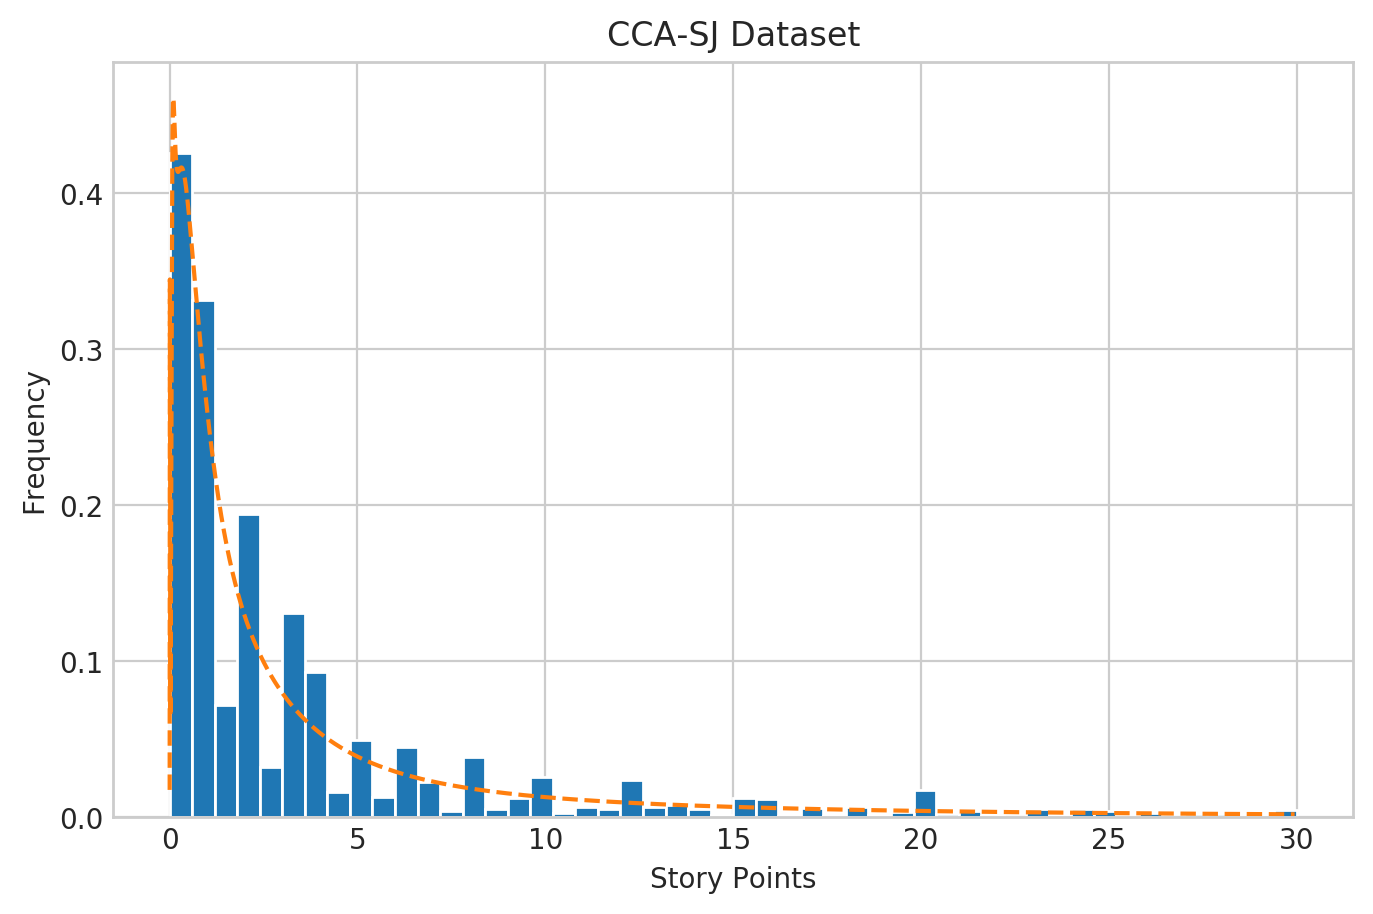

In [475]:
figura = plt.figure(figsize=(8, 5), dpi=200)
plt.xlabel("Story Points")
plt.ylabel("Frequency")
plt.title("CCA-SJ Dataset")
#sns.distplot(ccasj.estimated_hours.values, bins=np.linspace(0,49), kde=False)
plt.hist(ccasj.storypoint.values, bins=50, range=(0, 30), density=True)
#ccasj.estimated_hours.hist(bins=np.linspace(0,49,), normed=True)
#ccasj.estimated_hours.dropna().plot.kde(bw_method=0.01,xlim=(0,40), style='r--')
#x = np.linspace(ccasj.estimated_hours.min(), 40, 100)
plt.plot(ew, kde.density[w]/ew, linestyle='dashed')
#plt.plot(x, pareto_d2_eval(x, ccasj.estimated_hours.values, 10), linestyle='dashed')
#plt.plot(x, halfnorm.pdf(x, *halfnorm.fit(ccasj.estimated_hours.values)))
#plt.plot(x, chi.pdf(x, *chi.fit(ccasj.estimated_hours.values, 2)))
plt.show()
figura.savefig("reports/figures/ccasj.pdf", bbox_inches='tight')

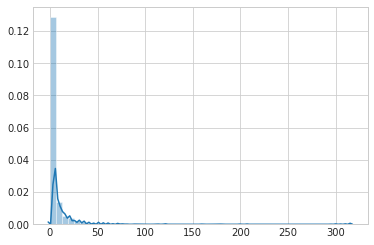

In [477]:
#sns.kdeplot(ccasj.estimated_hours.values)
sns.distplot(ccasj.storypoint.values)

In [238]:
plt.hist?

(array([0.01839579, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00613193, 0.        , 0.        ,
        0.00613193, 0.17629302, 0.        , 0.03219264, 0.09964388,
        0.13796845, 0.0536544 , 0.03985755, 0.61932505, 0.01839579,
        0.04139054, 0.01379685, 0.86153633, 0.0444565 , 0.15636424,
        0.52734608, 0.09504493, 0.34185516, 0.29586568, 0.17935899,
        0.15329828, 0.09197897, 0.14869933, 0.10424283, 0.13643547,
        0.088913  , 0.09504493, 0.05978633, 0.04905545, 0.03985755,
        0.02452772, 0.02606071, 0.01686281, 0.00613193, 0.00306597,
        0.00613193, 0.00153298, 0.00613193, 0.        , 0.00306597]),
 array([-4.60517021, -4.39795196, -4.19073371, -3.98351546, -3.77629721,
        -3.56907897, -3.36186072, -3.15464247, -2.94742422, -2.74020597,
        -2.53298772, -2.32576948, -2.11855123, -1.91133298, -1.70411473,
        -1.49689648, -1.28967823, -1.08245998, -0.87524174, -0.66802349,
        -0.46080524, -0.25

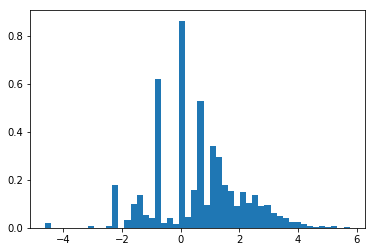

In [264]:
plt.hist(np.log(ccasj.estimated_hours.values), bins=50, density=True)

In [188]:
chi.fit(ccasj.estimated_hours.values)

(0.35982783033447885, 0.00999999977648258, 20.81692326187909)

In [184]:
chi.fit?

In [181]:
from scipy.stats import halfnorm, chi

In [170]:
halfnorm.fit(ccasj.estimated_hours.values)

(0.009999998753642518, 15.526912508624891)

array([33.57047525, 34.06261304, 34.55475084, 35.04688863, 35.53902643,
       36.03116422, 36.52330201, 37.01543981, 37.5075776 , 37.99971539,
       38.49185319, 38.98399098, 39.47612878, 39.96826657, 40.46040436,
       40.95254216, 41.44467995, 41.93681774, 42.42895554, 42.92109333,
       43.41323113, 43.90536892, 44.39750671, 44.88964451, 45.3817823 ,
       45.87392009, 46.36605789, 46.85819568, 47.35033348, 47.84247127,
       48.33460906, 48.82674686, 49.31888465, 49.81102244, 50.30316024,
       50.79529803, 51.28743582, 51.77957362, 52.27171141, 52.76384921,
       53.255987  , 53.74812479, 54.24026259, 54.73240038, 55.22453817,
       55.71667597, 56.20881376, 56.70095156, 57.19308935, 57.68522714,
       58.17736494, 58.66950273, 59.16164052, 59.65377832, 60.14591611,
       60.63805391, 61.1301917 , 61.62232949, 62.11446729, 62.60660508,
       63.09874287, 63.59088067, 64.08301846, 64.57515626, 65.06729405,
       65.55943184, 66.05156964, 66.54370743, 67.03584522, 67.52

In [337]:
print(table[['Median MAE', 'Median MdAE', 'Median SA']].to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Median MAE &  Median MdAE &  Median SA \\
\midrule
mesos              &        1.11 &         0.78 &      27.78 \\
usergrid           &        1.09 &         0.76 &      19.48 \\
appceleratorstudio &        1.43 &         0.28 &      37.14 \\
aptanastudio       &        3.01 &         2.45 &      30.80 \\
titanium           &        2.46 &         2.03 &      32.25 \\
duracloud          &        0.72 &         0.87 &      29.65 \\
bamboo             &        0.93 &         1.00 &      25.90 \\
clover             &        2.80 &         2.93 &      21.27 \\
jirasoftware       &        1.67 &         1.13 &      31.43 \\
moodle             &       10.32 &        11.14 &      14.84 \\
datamanagement     &        4.81 &         4.55 &      25.12 \\
mule               &        2.21 &         2.77 &      24.56 \\
mulestudio         &        3.24 &         2.30 &      22.03 \\
springxd           &        1.89 &         1.53 &      22.82 \\
talenddataqualit

In [336]:
table[['Project', 'Mean MAE', 'Mean MdAE', 'Mean SA']].to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  Mean MAE &  Mean MdAE &  Mean SA \\
\midrule
mesos              &      1.12 &       1.00 &    27.61 \\
usergrid           &      1.03 &       1.00 &    23.88 \\
appceleratorstudio &      1.28 &       0.00 &    43.98 \\
aptanastudio       &      3.08 &       3.00 &    29.13 \\
titanium           &      1.95 &       2.00 &    46.24 \\
duracloud          &      0.74 &       1.00 &    27.72 \\
bamboo             &      0.76 &       1.00 &    39.44 \\
clover             &      2.31 &       1.00 &    35.02 \\
jirasoftware       &      1.36 &       1.00 &    44.29 \\
moodle             &      6.46 &       5.00 &    46.71 \\
datamanagement     &      4.28 &       3.00 &    33.44 \\
mule               &      2.20 &       3.00 &    25.17 \\
mulestudio         &      3.14 &       3.00 &    24.34 \\
springxd           &      1.68 &       2.00 &    31.24 \\
talenddataquality  &      3.13 &       3.00 &    29.74 \\
talendesb          &      0.70 &       1.00 &   

In [500]:
metrics = {}
for project in project_repos.keys():
    story_points = pd.read_csv(data_path % project)['storypoint'].values.clip(1, story_points_clip[project]).astype('int32')
    #story_points = pd.read_csv(data_path % project)['storypoint'].values.astype('int32')
    num_test = int(round(len(story_points)*0.2))
    count_train = np.bincount(story_points[:-num_test], minlength=story_points.max())
    count_train = count_train/np.sum(count_train)
    count_test = np.bincount(story_points[-num_test:], minlength=story_points.max())
    count_test = count_test/np.sum(count_test)
    count = np.dot(count_train.reshape((-1,1)), count_test.reshape((1, -1)))
    random_mae = 0
    for i in range(1, count.shape[0]):
        random_mae += i * (count.trace(i) + count.trace(-i))
    median_mae = np.mean(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_mdae = np.median(np.abs(np.median(story_points[:-num_test]) - story_points[-num_test:]))
    median_sa = (1 - median_mae/random_mae) * 100
    mean_mae = np.mean(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_mdae = np.median(np.abs(np.mean(story_points[:-num_test]) - story_points[-num_test:]))
    mean_sa = (1 - mean_mae/random_mae) * 100
    metrics[project] = [project_name[project], mean_mae, mean_mdae, mean_sa, median_mae, median_mdae, median_sa]
table = pd.DataFrame.from_dict(metrics, orient='index', columns=['Project', 'Mean MAE', 'Mean MdAE', 'Mean SA', 'Median MAE', 'Median MdAE', 'Median SA'])
table

,Project,Mean MAE,Mean MdAE,Mean SA,Median MAE,Median MdAE,Median SA
mesos,Mesos,1.11,0.78,27.78,1.12,1.00,27.61
usergrid,Usergrid,1.09,0.76,19.48,1.03,1.00,23.88
appceleratorstudio,Appcelerator Studio,1.43,0.28,37.14,1.28,0.00,43.98
aptanastudio,Aptana Studio,3.01,2.45,30.80,3.08,3.00,29.13
titanium,Titanium SDK/CLI,2.46,2.03,32.25,1.95,2.00,46.24
duracloud,DuraCloud,0.72,0.87,29.65,0.74,1.00,27.72
bamboo,Bamboo,0.93,1.00,25.90,0.76,1.00,39.44
clover,Clover,2.80,2.93,21.27,2.31,1.00,35.02
jirasoftware,Jira Software,1.67,1.13,31.43,1.36,1.00,44.29
moodle,Moodle,10.32,11.14,14.84,6.46,5.00,46.71


In [501]:
with open(tex_output % 'deep-se-mean-reproduction', 'w') as file:
    table.to_latex(index=False, columns=['Project', 'Mean MAE', 'Mean MdAE', 'Mean SA'], buf=file)
with open(tex_output % 'deep-se-median-reproduction', 'w') as file:
    table.to_latex(index=False, columns=['Project', 'Median MAE', 'Median MdAE', 'Median SA'], buf=file)

In [538]:
table.to_latex?

In [334]:
pd.options.display.float_format = '{:,.2f}'.format

In [40]:
np.bincount?

In [6]:
pd.DataFrame.add?

In [ ]:
min(story_points)

In [ ]:

count

In [ ]:
count.trace(1)

In [ ]:
np.sum(count.diagonal(1))

In [17]:
import io

def carrega_vetor(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=np.float32)
    return data

vetores = carrega_vetor('word_embeddings/crawl-300d-2M.vec')

In [35]:
vetores['UNK'].shape

(300,)

In [522]:
with open('models/en/dic/apache.dic.pkl',"rb") as file:
    dic =  pickle.load(file)

In [529]:
vetores['UNK']

array([-9.380e-02,  1.500e-02,  3.099e-01,  2.048e-01, -2.340e-02,
       -4.412e-01,  4.000e-04, -3.345e-01, -4.470e-02, -1.476e-01,
       -1.818e-01,  6.979e-01, -2.868e-01, -1.835e-01,  1.640e-01,
       -1.026e-01,  8.330e-02, -8.620e-02,  1.354e-01, -2.294e-01,
        7.480e-02,  1.075e-01,  3.199e-01,  2.010e-01, -1.331e-01,
        4.564e-01, -2.769e-01, -5.239e-01,  4.614e-01, -9.570e-02,
       -2.537e-01,  9.377e-01,  2.097e-01,  1.765e-01,  2.480e-01,
       -1.457e-01,  6.450e-02,  3.546e-01, -1.897e-01, -2.693e-01,
       -1.115e-01, -9.610e-02,  2.590e-01,  1.989e-01,  1.290e-02,
       -9.980e-02,  3.980e-02,  2.826e-01, -3.171e-01, -1.082e-01,
        3.440e-02, -5.770e-02,  6.255e-01, -7.437e-01, -2.464e-01,
        3.329e-01, -1.487e-01,  4.166e-01,  6.210e-02, -8.510e-02,
       -1.985e-01,  3.000e-03,  5.228e-01,  3.199e-01,  1.596e-01,
        8.000e-03,  5.860e-01, -4.313e-01,  8.220e-02, -5.560e-02,
       -4.700e-02,  1.167e-01, -8.430e-02, -5.426e-01, -2.529e

In [526]:
del dic['EOF_VALUE']
del dic['UNK_VALUE']

In [530]:
wbs = np.zeros((len(dic),vetores['a'].shape[0]))
for i, k in enumerate(dic.keys()):
    try:
        wbs[i] = vetores[k]
    except:
        wbs[i] = vetores['UNK']
        print(k, end=', ')

n't, _, noformat, /wsdl, complextype, `, type="xsd, /xs, /xsd, nillable="true, ~[apache, /usr, minoccurs="0, /home, string"/, java.lang.nullpointerexception, sun.reflect.nativemethodaccessorimpl.invoke0(native, type="xs, cqlsh, java.lang.runtimeexception, /soapenv, c++, dtest, maxoccurs="1, /var, /users, /s, ~[main/:na, camelcontext, java.io.ioexception, amq, @@, /complextype, simpletype, encoding/, version="1.0, java.lang.thread.run(thread.java:745, wsdlsoap, sun.reflect.delegatingmethodaccessorimpl.invoke(delegatingmethodaccessorimpl.java:25, porttype, encoding="utf-8, /sequence, org.apache.axis2.axisfault, xsd="http://www.w3.org/2001/xmlschema, java2wsdl, use="literal"/, axisfault, sun.reflect.nativemethodaccessorimpl.invoke(nativemethodaccessorimpl.java:39, java.lang.string, envelope/, kahadb, xsi="http://www.w3.org/2001/xmlschema, message="tns, gems/1.8/gems, /tmp, type="s, ------------------------------------------------------------------------, sun.reflect.delegatingmethodaccess

In [531]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.019s...
[t-SNE] Computed neighbors for 2000 samples in 2.461s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.190331
[t-SNE] KL divergence after 10000 iterations: 1.718274


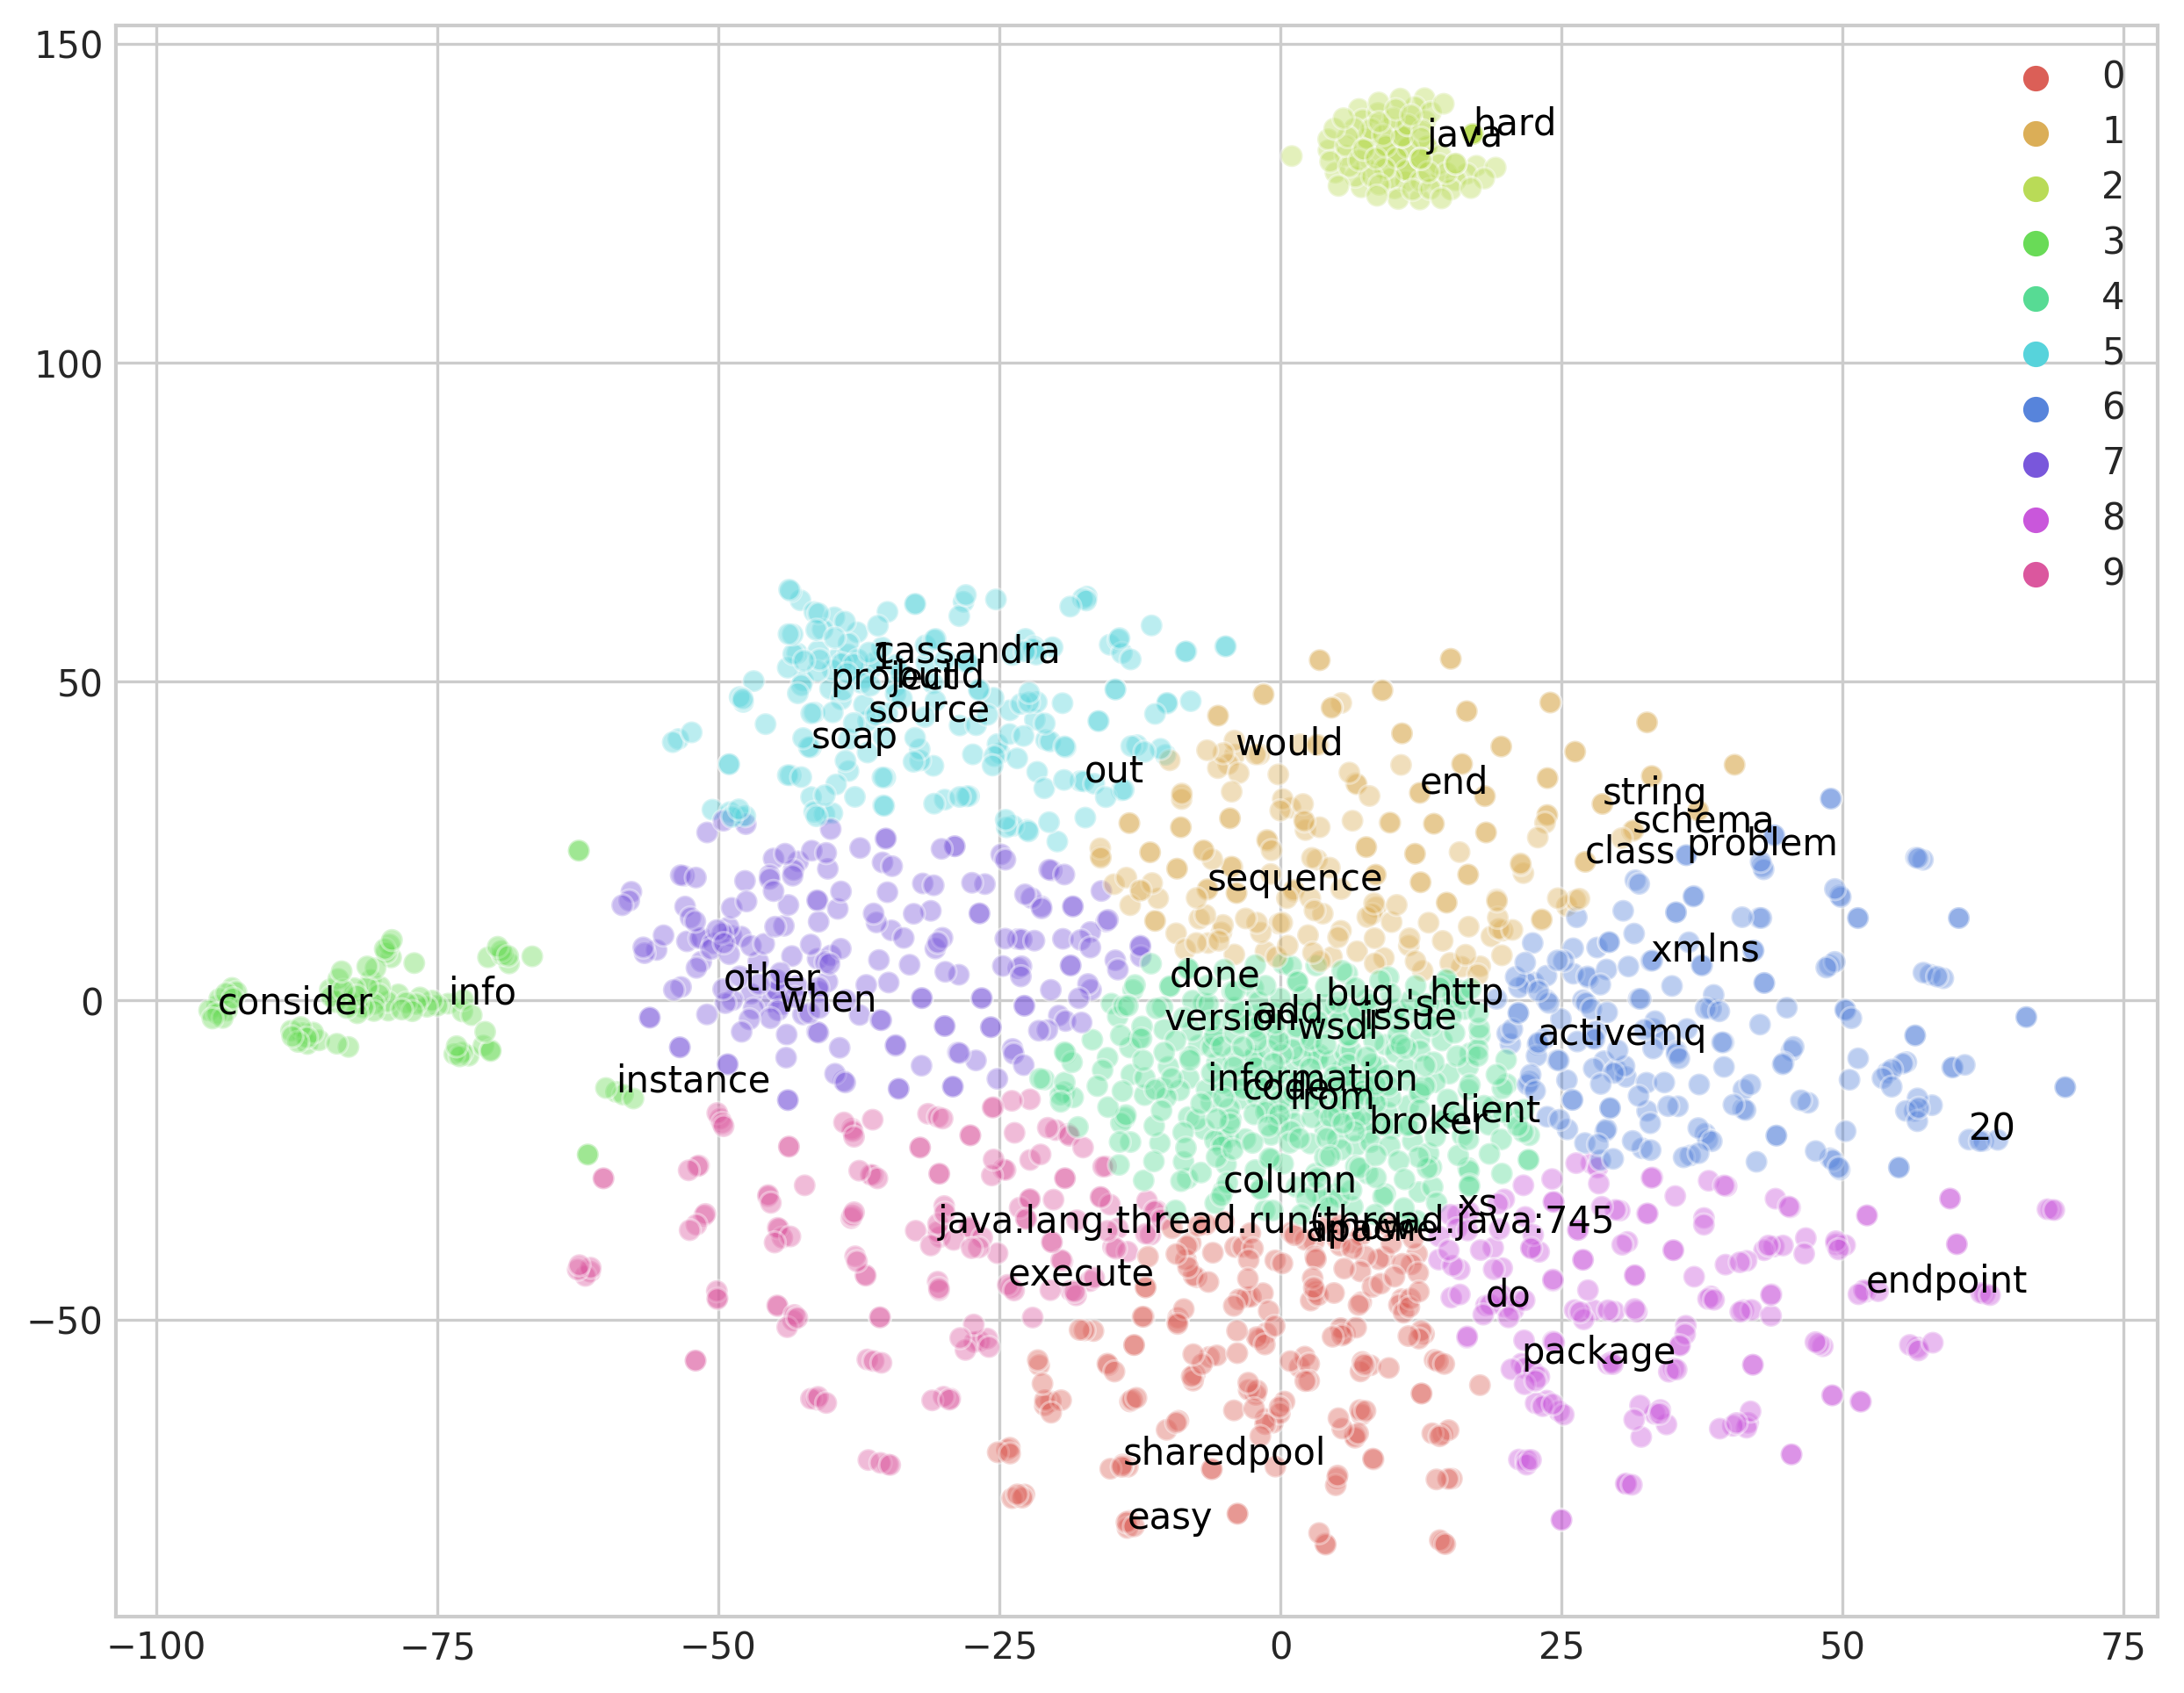

In [536]:
tsne = TSNE(n_components=2, verbose=1, n_iter=10000)
tsne_results = tsne.fit_transform(wbs)
k = KMeans(n_clusters=10, random_state=0).fit(tsne_results)
fig = plt.figure(figsize=(10,8), dpi=300)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=k.labels_,
    palette=sns.color_palette("hls", 10),
    alpha=0.4
)

for i in ['out', 'easy', 'hard','when', 'instance','source','1','20','from','endpoint', 'end','issue','in','\'s','java.lang.thread.run(thread.java:745','sharedpool', 'cassandra','xmlns','would','problem', 'bug','project','do', 'wsdl','xs', 'client','schema', 'execute', 'http','code','column', 'apache','add', 'broker', 'sequence','version','package','build', 'other', 'consider', 'info', 'java', 'string', 'class', 'soap', 'activemq', 'information', 'now', 'done']:
    plt.annotate(i, (tsne_results[dic[i],0], tsne_results[dic[i],1]), color='black')
fig.savefig("reports/figures/apache-tsne-fastext.pdf", bbox_inches='tight')

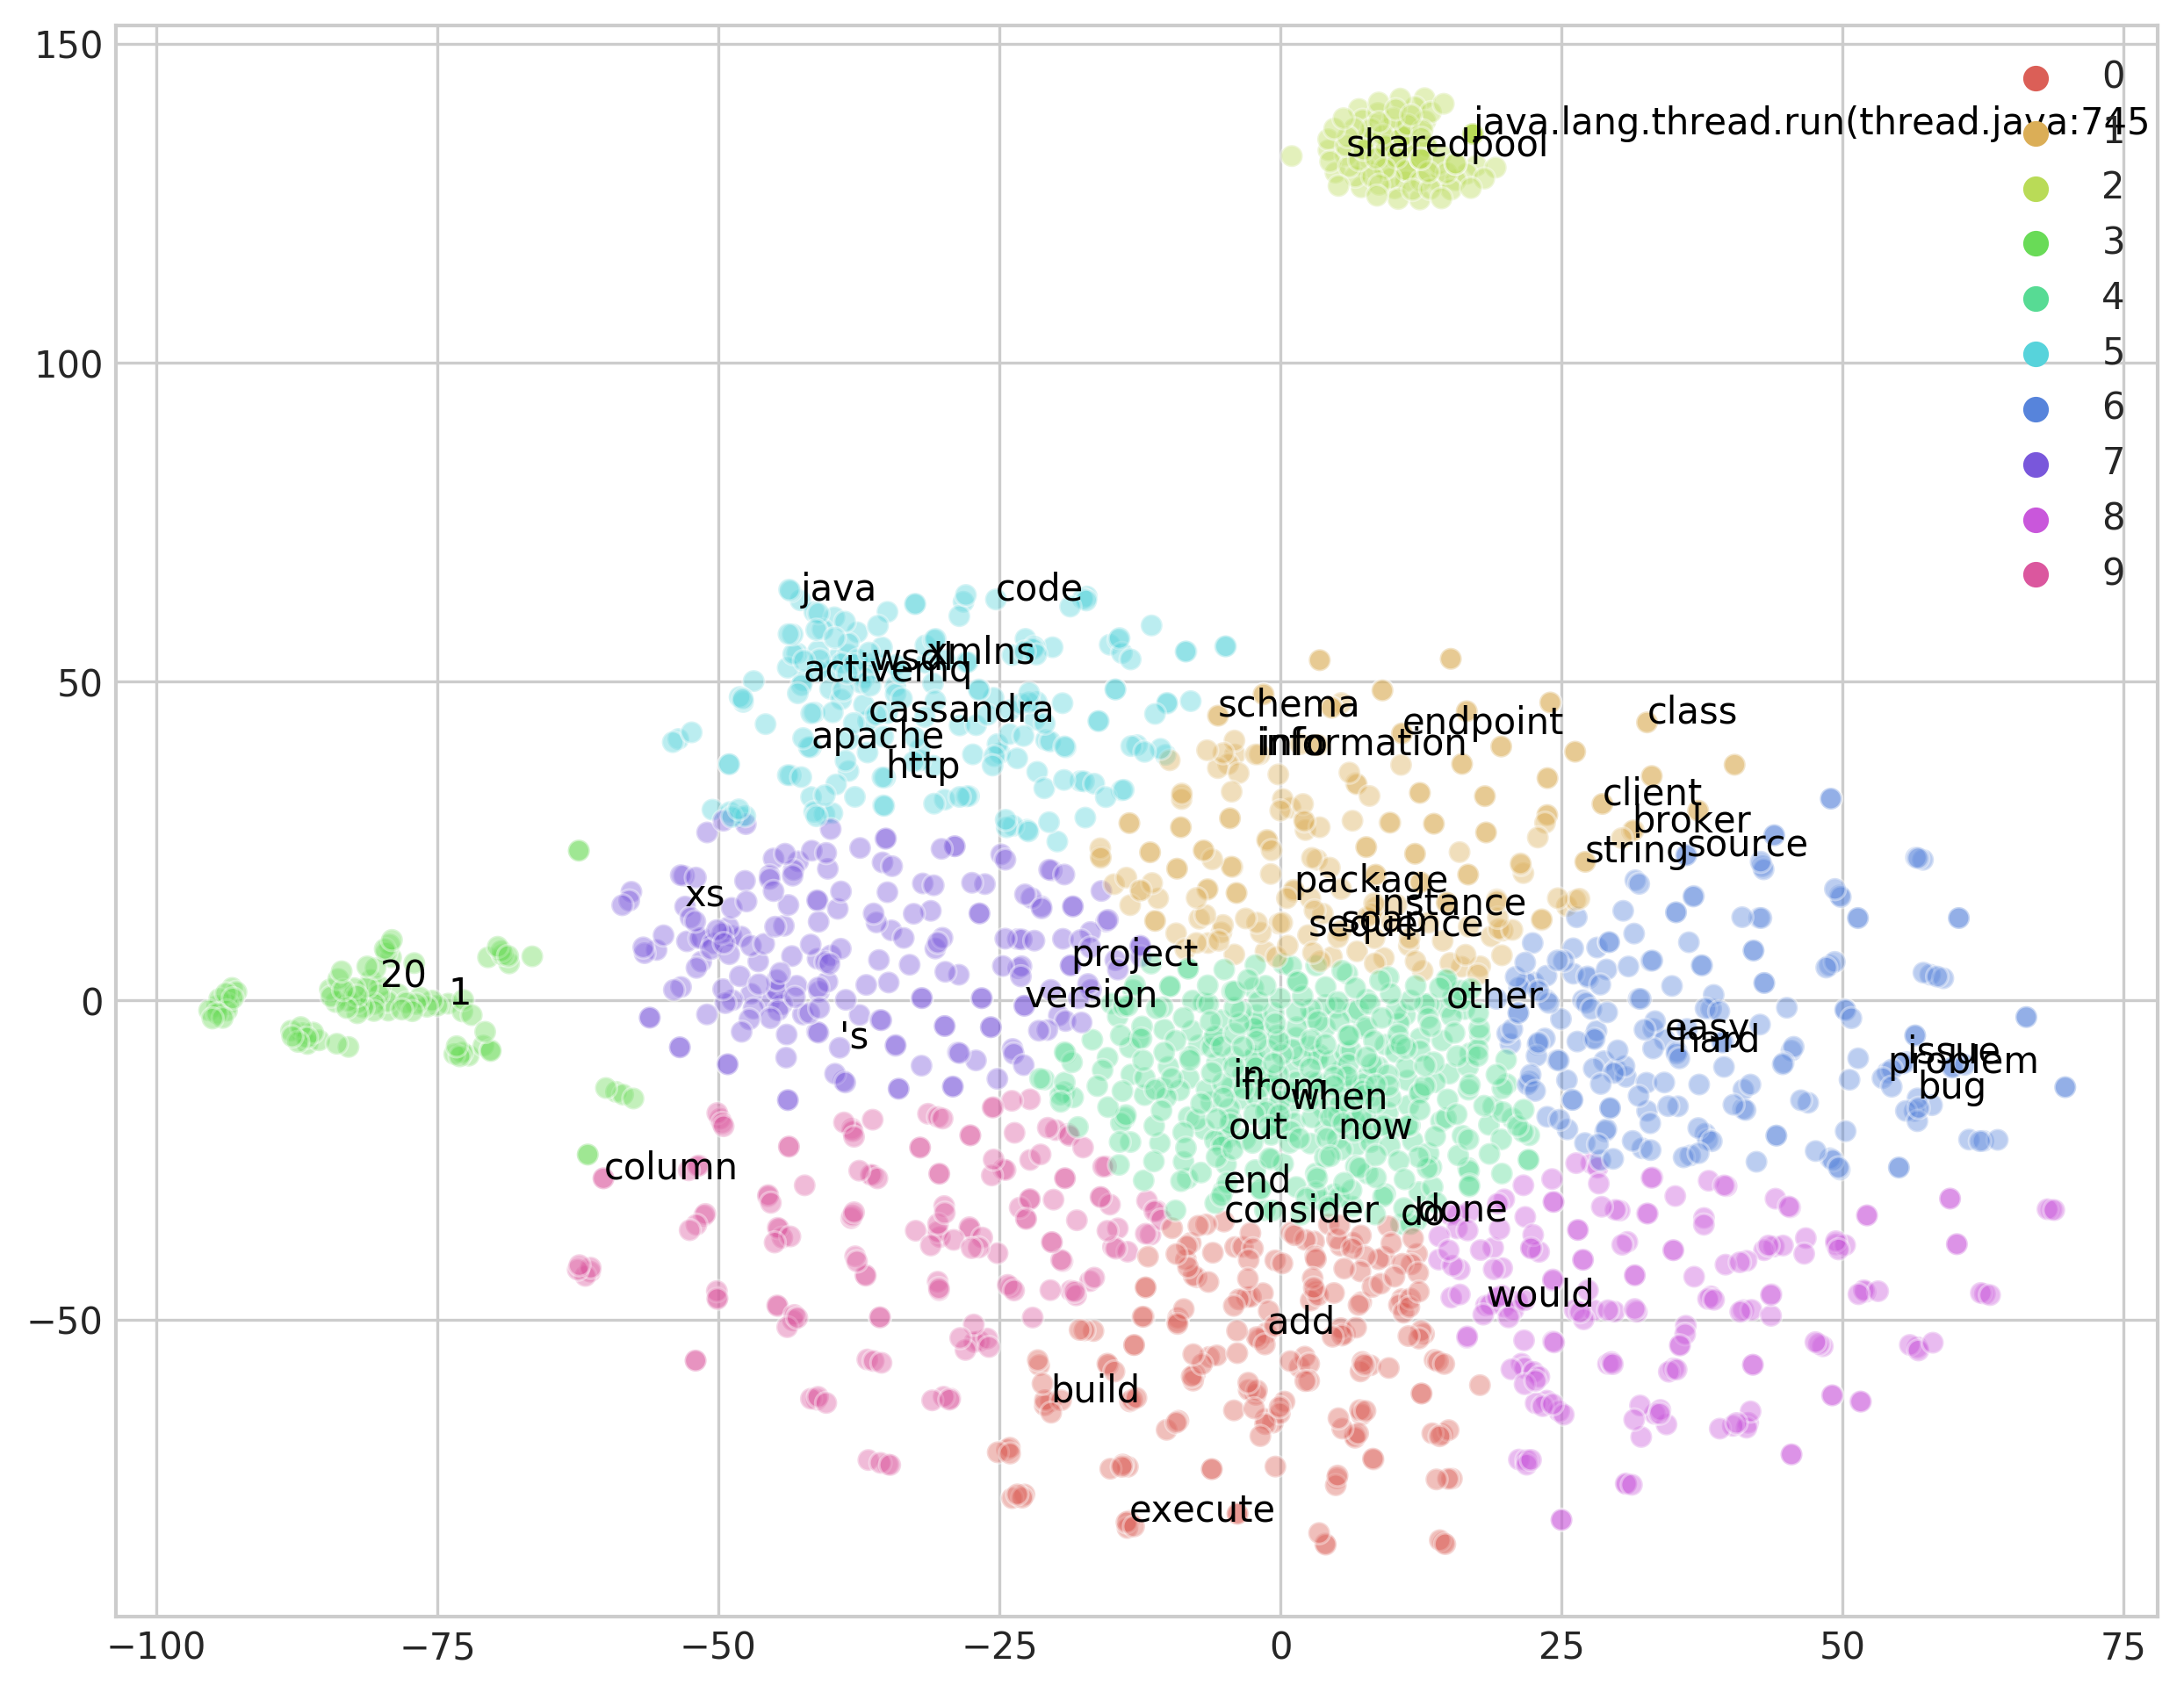

In [537]:
fig = plt.figure(figsize=(10,8), dpi=300)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=k.labels_,
    palette=sns.color_palette("hls", 10),
    alpha=0.4
)

for i in ['out', 'easy', 'hard','when', 'instance','source','1','20','from','endpoint', 'end','issue','in','\'s','java.lang.thread.run(thread.java:745','sharedpool', 'cassandra','xmlns','would','problem', 'bug','project','do', 'wsdl','xs', 'client','schema', 'execute', 'http','code','column', 'apache','add', 'broker', 'sequence','version','package','build', 'other', 'consider', 'info', 'java', 'string', 'class', 'soap', 'activemq', 'information', 'now', 'done']:
    plt.annotate(i, (tsne_results[dic[i]-2,0], tsne_results[dic[i]-2,1]), color='black')
fig.savefig("reports/figures/apache-tsne-fastext.pdf", bbox_inches='tight')